In [143]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [23]:
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# data
df = yf.download(["CAD=X", "AUDUSD=X"], start="2009-12-19", end="2012-04-12", auto_adjust = True)
df = df['Close']

[*********************100%***********************]  2 of 2 completed


## Trading Currency Cross-Rates

In [3]:
cad = 1 / df['CAD=X']
aud = df["AUDUSD=X"]

y = pd.concat([aud.rename("AUD"), cad.rename("CAD")], axis=1).dropna()
y

,AUD,CAD
Date,,
2009-12-21,0.880592,0.942063
2009-12-22,0.876501,0.945984
2009-12-23,0.879817,0.953562
2009-12-24,0.884564,0.952381
2009-12-25,0.885034,0.953289
...,...,...
2012-04-05,1.028098,1.003714
2012-04-06,1.029516,1.006948
2012-04-09,1.028796,1.002607


In [75]:
training = 250
lookback = 20

# hedge_ratio = pd.Series(np.nan, index = y.index)
hedge_ratio = pd.DataFrame(np.nan, index = y.index, columns = y.columns)
num_units = pd.Series(np.nan, index=y.index, name="numUnits")

<h3 style="color:red">Incorrect results</h1>

np.float64(0.07152442554154348)

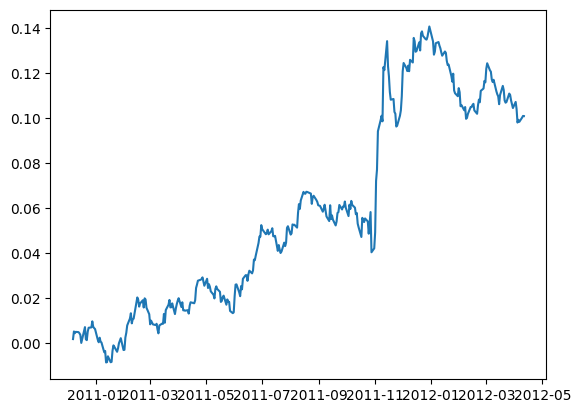

In [155]:
for i in range(training, len(y)):
    w = np.log(y[i - training: i])
    joha = coint_johansen(w, det_order = 0, k_ar_diff = 1)

    beta = joha.evec[:, 0]
    hedge_ratio.iloc[i - 1, :] = joha.evec[:, 0]
    
    yport = (y[i - lookback + 1: i + 1] * beta).sum(axis = 1)
    
    ma = np.mean(yport)
    mstd = np.std(yport, ddof = 1)
    
    zscore = (yport.iloc[-1] - ma) / mstd
    num_units.iloc[i] = -(yport[-1] - ma) / mstd

positions = y.mul(hedge_ratio).mul(num_units, axis=0)

prices = (y - y.shift(1)) / y.shift(1)
pnl = np.sum(positions.shift(1) * prices, axis = 1)

ret = pnl / np.abs(positions.shift(1)).sum(axis = 1)
ret = ret[~np.isnan(ret)]

cum_ret = np.cumprod(1 + ret) - 1
plt.plot(cum_ret)

APR = np.prod(1 + ret) ** (252 / len(ret)) - 1
APR

## Rollover Interests in Currency Trading

In [175]:
import scipy.io
import numpy as np
from datetime import datetime

mat = scipy.io.loadmat('../data/inputDataDaily_CL_20120813.mat') # load .mat file
contracts = [item for sublist in np.array(mat['contracts']) for items in sublist for item in items]
tday = pd.DataFrame(mat['tday'])
tday.columns = ['tday']
cl = pd.DataFrame(mat['cl'])
cl.columns = contracts

temp = pd.concat([cl, tday], axis=1)
spot = temp[['tday','0000$']]
contracts = contracts.remove('0000$')
cl = cl.drop('0000$', axis=1)
cl.head()

,2007F,2007G,2007H,2007J,2007K,2007M,2007N,2007Q,2007U,2007V,...,2013Q,2013U,2013V,2013X,2013Z,2014F,2014G,2014H,2014J,2014K
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
spot['gamma'] = np.nan
for t in range(spot.shape[0]):
    ft = cl.iloc[t]
    idx = ft.reset_index().index
    idx_list = idx.tolist()
    idx_list_no_na = [idx_list[i] for i in range(len(ft)) if not ft.isna()[i]] # get rid of NAN ones
    idx_no_na = pd.Series(idx_list_no_na)
    idx_diff = idx_no_na.shift(-1) - idx_no_na
    if len(idx_no_na) >= 5 and any(idx_diff[0:3]==1):
        ft_new = list(ft[idx_no_na[0:4]]) # use list instead of pd.Series so that sm.OLS can handle it
        tt = range(len(ft_new))
        tt = sm.add_constant(tt) # add constant for `statsmodels.api.OLS` to work
        beta = sm.OLS(ft_new,tt).fit().params[1] # return slope from `OLS`
        spot.loc[t, 'gamma'] = -12 * beta
spot['gamma'].tail()

/var/folders/bc/hnzwjdn546lcc572zg36k_vc0000gn/T/ipykernel_74261/3522858510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spot['gamma'] = np.nan


6462   -3.864
6463   -4.152
6464   -3.936
6465   -3.792
6466   -4.080
Name: gamma, dtype: float64